In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

In [2]:
# set up simulation constants

resolution = 20

n_air = 1.0000003
n_siox = 1.45
a = 0.5   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_hole = 5
height_siox = 5+0.780
height_air = 0.3

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + height_siox + height_air, 3)


center_siox = round(pml_thickness + 0.5*height_siox- 0.5*cell_z, 3)
center_hole = center_siox+0.780
center_air = round(pml_thickness + height_siox + 0.5* height_air -0.5*cell_z,3)
#center_air = round(0.5*(pml_thickness + height_air + height_hole) + (pml_thickness+height_siox)-0.5*cell_z,3)

z_siox = pml_thickness+height_siox
z_air = height_hole+height_air+pml_thickness


#z_siox = pml_thickness + height_siox +height_space


In [3]:


geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_air), 
                  center=mp.Vector3(0,0,center_air),
                  material=mp.Medium(index=n_air))]

k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 30 # this is the number of pillars we will build
data = np.zeros((3,num))

## set up and build source ##
############################

center_source = round(pml_thickness + height_siox*0.2 - 0.6*cell_z, 3) 
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]



/home/june/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/june/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


-0.15
0.63
2.89
[<meep.geom.Block object at 0x7fb2ad791b90>, <meep.geom.Block object at 0x7fb2ad7c0ad0>]
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


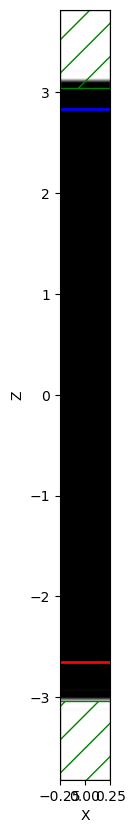

In [4]:
## Set up simulation ##
######################

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]


geometry=[mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_air),
                    center=mp.Vector3(0,0,center_air),
                    material=mp.Medium(index=n_air))]

geometry =[mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_hole), 
                   center=mp.Vector3(0,0,center_hole),
                   material=mp.Medium(index=n_air))]

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_siox),
                    center=mp.Vector3(0,0,center_siox),
                     material=mp.Medium(index=n_air)))


print(center_siox)
print(center_hole)
print(center_air)



sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.7*height_air, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)
min = 0.0
max = 0.245

print (geometry)

fig = plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)
fig.savefig("test.png")


In [5]:
sim.run(until=200)

initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux
sim.reset_meep()

geometry =[mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_hole), 
                   center=mp.Vector3(0,0,center_hole),
                   material=mp.Medium(index=n_siox))]

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_siox),
                    center=mp.Vector3(0,0,center_siox),
                     material=mp.Medium(index=n_siox)))

pbar = tqdm(total=num,leave=False)
for i,radius in enumerate(np.linspace(min,max,num=num)):

    geometry.append(mp.Cylinder(radius=radius,
                        height=height_hole,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_hole),
                        material=mp.Medium(index=n_air)))

    
                                
    #geometry=mp.Cylinder(radius=radius,


    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)

    flux_object = sim.add_flux(freq, df, nfreq, fr)  

    sim.run(until=200)
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase

    
    if(radius!=max):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()

                            


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000781059 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0325301 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


  0%|                                                 | 0/30 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00100422 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0297122 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.935484) = 0.645161 after 7 iters
Dominant planewave for band 1: (0.000000,0.000000,0.935484)


  3%|█▎                                       | 1/30 [00:01<00:34,  1.18s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 0,radius=0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00131202 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.00844828, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0319839 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.799968) = 0.551702 after 8 iters
MPB solved for frequency_1(0,0,0.935484) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.935484)


  7%|██▋                                      | 2/30 [00:02<00:34,  1.23s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 1,radius=0.008448275862068965
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000782013 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0168966, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0306849 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.799968) = 0.551702 after 8 iters
MPB solved for frequency_1(0,0,0.935484) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.935484)


 10%|████                                     | 3/30 [00:03<00:33,  1.22s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 2,radius=0.01689655172413793
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00077486 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0253448, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0537601 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.725293) = 0.502081 after 7 iters
MPB solved for frequency_1(0,0,0.931995) = 0.645157 after 5 iters
MPB solved for frequency_1(0,0,0.932) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.932000)


 13%|█████▍                                   | 4/30 [00:04<00:32,  1.26s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 3,radius=0.025344827586206896
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00108314 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0337931, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0530529 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.694534) = 0.481859 after 7 iters
MPB solved for frequency_1(0,0,0.929942) = 0.64515 after 5 iters
MPB solved for frequency_1(0,0,0.929959) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.929959)


 17%|██████▊                                  | 5/30 [00:06<00:31,  1.26s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 4,radius=0.03379310344827586
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000921011 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0422414, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.084394 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.66992) = 0.466019 after 7 iters
MPB solved for frequency_1(0,0,0.927502) = 0.645136 after 5 iters
MPB solved for frequency_1(0,0,0.927538) = 0.645161 after 2 iters
Dominant planewave for band 1: (0.000000,0.000000,0.927538)


 20%|████████▏                                | 6/30 [00:07<00:31,  1.30s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 5,radius=0.04224137931034482
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000720024 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0506897, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0714178 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.648803) = 0.452756 after 7 iters
MPB solved for frequency_1(0,0,0.924621) = 0.645113 after 6 iters
MPB solved for frequency_1(0,0,0.92469) = 0.645161 after 2 iters
Dominant planewave for band 1: (0.000000,0.000000,0.924690)


 23%|█████████▌                               | 7/30 [00:08<00:29,  1.30s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 6,radius=0.05068965517241379
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000617027 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0591379, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.086772 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.452095 after 7 iters
MPB solved for frequency_1(0,0,0.920833) = 0.645084 after 6 iters
MPB solved for frequency_1(0,0,0.920944) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.920944) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.920944)


 27%|██████████▉                              | 8/30 [00:10<00:29,  1.33s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 7,radius=0.059137931034482755
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00125289 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0675862, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0896611 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.454352 after 7 iters
MPB solved for frequency_1(0,0,0.91634) = 0.645046 after 5 iters
MPB solved for frequency_1(0,0,0.916504) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.916504) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.916504)


 30%|████████████▎                            | 9/30 [00:11<00:28,  1.33s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 8,radius=0.06758620689655172
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000533104 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0760345, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.096118 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.456999 after 7 iters
MPB solved for frequency_1(0,0,0.911145) = 0.644997 after 6 iters
MPB solved for frequency_1(0,0,0.911378) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.911378) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.911378)


 33%|█████████████▎                          | 10/30 [00:12<00:26,  1.34s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 9,radius=0.07603448275862068
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000822067 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.0844828, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.102829 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.459791 after 7 iters
MPB solved for frequency_1(0,0,0.905729) = 0.644948 after 6 iters
MPB solved for frequency_1(0,0,0.90603) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.90603) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.906030)


 37%|██████████████▋                         | 11/30 [00:14<00:25,  1.34s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 10,radius=0.08448275862068964
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000674009 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.092931, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0829539 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.462616 after 7 iters
MPB solved for frequency_1(0,0,0.900312) = 0.644901 after 6 iters
MPB solved for frequency_1(0,0,0.900677) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.900677) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.900677)


 40%|████████████████                        | 12/30 [00:15<00:24,  1.34s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 11,radius=0.0929310344827586
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.001127 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.101379, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0825078 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.465676 after 7 iters
MPB solved for frequency_1(0,0,0.894523) = 0.644853 after 6 iters
MPB solved for frequency_1(0,0,0.894953) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.894953) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.894953)


 43%|█████████████████▎                      | 13/30 [00:16<00:22,  1.33s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 12,radius=0.10137931034482758
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000729084 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.109828, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.079119 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.469378 after 7 iters
MPB solved for frequency_1(0,0,0.8876) = 0.644805 after 6 iters
MPB solved for frequency_1(0,0,0.888092) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.888092) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.888092)


 47%|██████████████████▋                     | 14/30 [00:18<00:21,  1.31s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 13,radius=0.10982758620689655
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000693798 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.118276, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.074306 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.473543 after 7 iters
MPB solved for frequency_1(0,0,0.879934) = 0.644758 after 6 iters
MPB solved for frequency_1(0,0,0.880488) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.880488) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.880488)


 50%|████████████████████                    | 15/30 [00:19<00:19,  1.30s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 14,radius=0.11827586206896551
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000734091 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.126724, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0893059 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.47815 after 7 iters
MPB solved for frequency_1(0,0,0.87161) = 0.644711 after 6 iters
MPB solved for frequency_1(0,0,0.872224) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.872224) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.872224)


 53%|█████████████████████▎                  | 16/30 [00:20<00:18,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 15,radius=0.12672413793103446
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000764132 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.135172, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0963659 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.482725 after 8 iters
MPB solved for frequency_1(0,0,0.863467) = 0.644681 after 6 iters
MPB solved for frequency_1(0,0,0.864116) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.864116) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.864116)


 57%|██████████████████████▋                 | 17/30 [00:22<00:16,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 16,radius=0.13517241379310344
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000687122 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.143621, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0917311 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.487547 after 8 iters
MPB solved for frequency_1(0,0,0.855023) = 0.644663 after 6 iters
MPB solved for frequency_1(0,0,0.85569) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.85569) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.855690)


 60%|████████████████████████                | 18/30 [00:23<00:15,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 17,radius=0.1436206896551724
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000782013 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.152069, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.088702 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.492798 after 7 iters
MPB solved for frequency_1(0,0,0.845997) = 0.644654 after 6 iters
MPB solved for frequency_1(0,0,0.846671) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.846671) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.846671)


 63%|█████████████████████████▎              | 19/30 [00:24<00:14,  1.28s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 18,radius=0.15206896551724136
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00136399 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.160517, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0883801 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.49876 after 7 iters
MPB solved for frequency_1(0,0,0.835934) = 0.64466 after 6 iters
MPB solved for frequency_1(0,0,0.836591) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.836591) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.836591)


 67%|██████████████████████████▋             | 20/30 [00:25<00:13,  1.30s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 19,radius=0.16051724137931034
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000755072 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.168966, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0876338 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.505184 after 7 iters
MPB solved for frequency_1(0,0,0.825337) = 0.644677 after 5 iters
MPB solved for frequency_1(0,0,0.825965) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.825965) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.825965)


 70%|████████████████████████████            | 21/30 [00:27<00:11,  1.30s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 20,radius=0.1689655172413793
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00142503 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.177414, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.130868 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.512254 after 7 iters
MPB solved for frequency_1(0,0,0.81396) = 0.644702 after 6 iters
MPB solved for frequency_1(0,0,0.814547) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.814547) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.814547)


 73%|█████████████████████████████▎          | 22/30 [00:28<00:10,  1.31s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 21,radius=0.17741379310344826
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000790119 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.185862, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.093622 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.519493 after 7 iters
MPB solved for frequency_1(0,0,0.80258) = 0.644744 after 6 iters
MPB solved for frequency_1(0,0,0.803107) = 0.645161 after 4 iters
MPB solved for frequency_1(0,0,0.803107) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.803107)


 77%|██████████████████████████████▋         | 23/30 [00:29<00:09,  1.32s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 22,radius=0.1858620689655172
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000859976 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.19431, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.10694 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.527228 after 7 iters
MPB solved for frequency_1(0,0,0.790736) = 0.644794 after 6 iters
MPB solved for frequency_1(0,0,0.791192) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.791192) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.791192)


 80%|████████████████████████████████        | 24/30 [00:31<00:07,  1.31s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 23,radius=0.1943103448275862
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000582933 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.202759, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.126803 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.535446 after 7 iters
MPB solved for frequency_1(0,0,0.778505) = 0.64485 after 5 iters
MPB solved for frequency_1(0,0,0.778885) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.778885) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.778885)


 83%|█████████████████████████████████▎      | 25/30 [00:32<00:06,  1.31s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 24,radius=0.20275862068965517
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000900984 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.211207, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.12117 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.544522 after 7 iters
MPB solved for frequency_1(0,0,0.765405) = 0.644911 after 5 iters
MPB solved for frequency_1(0,0,0.765706) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.765706) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.765706)


 87%|██████████████████████████████████▋     | 26/30 [00:33<00:05,  1.33s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 25,radius=0.21120689655172412
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000769138 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.219655, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.122256 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.554629 after 8 iters
MPB solved for frequency_1(0,0,0.751316) = 0.644971 after 5 iters
MPB solved for frequency_1(0,0,0.75154) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.75154) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.751540)


 90%|████████████████████████████████████    | 27/30 [00:35<00:04,  1.33s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 26,radius=0.2196551724137931
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000681877 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.228103, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.10119 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.565194 after 8 iters
MPB solved for frequency_1(0,0,0.737129) = 0.645025 after 5 iters
MPB solved for frequency_1(0,0,0.737286) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.737286) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.737286)


 93%|█████████████████████████████████████▎  | 28/30 [00:36<00:02,  1.33s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 27,radius=0.22810344827586204
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000751019 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.236552, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.105835 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.573666 after 9 iters
MPB solved for frequency_1(0,0,0.726118) = 0.645063 after 6 iters
MPB solved for frequency_1(0,0,0.72623) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.72623) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.726230)


 97%|██████████████████████████████████████▋ | 29/30 [00:37<00:01,  1.34s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 28,radius=0.23655172413793102
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000815868 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.245, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.103278 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.581305 after 9 iters
MPB solved for frequency_1(0,0,0.716471) = 0.645092 after 6 iters
MPB solved for frequency_1(0,0,0.716549) = 0.645161 after 3 iters
MPB solved for frequency_1(0,0,0.716549) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.716549)


     block, center = (0,0,0.63)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.63)
          radius 0.245, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


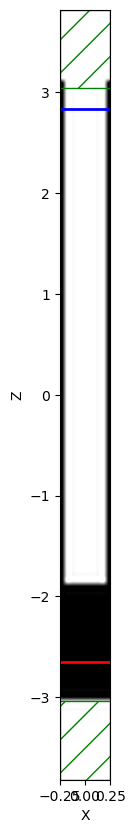

In [6]:
# plot an x-z cross section

plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)

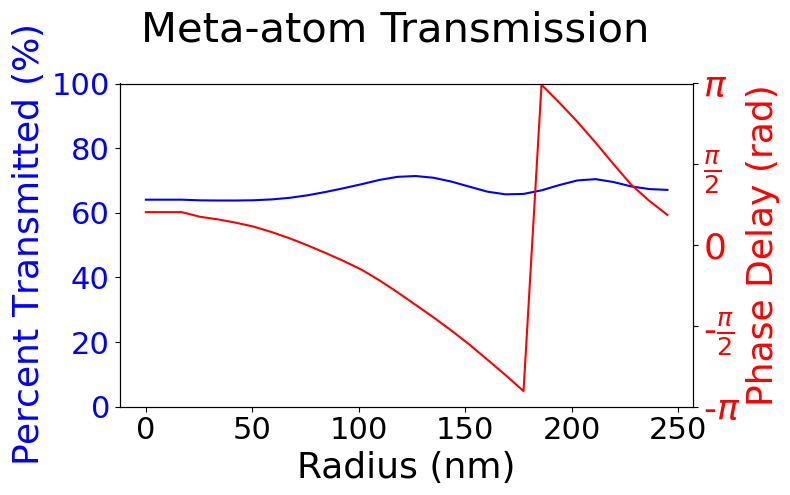

In [7]:
radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

#plt.style.use('seaborn')

results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phas and transmission

tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

#ax.set_title("Transmission Magnitude",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
#ax.plot(radii,flux_list,'b',label='Transmission')
ax.plot(radii, flux_list, 'b', label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])
#ax.set_yticklabels([60,70,80,90,100],fontsize=ticgit config --global user.email "you@example.com"kfontsize)

twin1 = ax.twinx()
#ax[1].set_title("Transmission Phase",fontsize=titlefontsize)S
#ax[1].set_xlabel("Radius (nm)",fontsize=labelfontsize)
#ax[1].set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])cd meep

#ax[1].set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')
#ax[1].legend(loc="upper right")
#plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()





In [8]:
print(radii)

[0.         0.00844828 0.01689655 0.02534483 0.0337931  0.04224138
 0.05068966 0.05913793 0.06758621 0.07603448 0.08448276 0.09293103
 0.10137931 0.10982759 0.11827586 0.12672414 0.13517241 0.14362069
 0.15206897 0.16051724 0.16896552 0.17741379 0.18586207 0.19431034
 0.20275862 0.2112069  0.21965517 0.22810345 0.23655172 0.245     ]


In [9]:
print(flux_list)

[0.64054634 0.64054634 0.64054634 0.63853145 0.63801312 0.6379714
 0.63873875 0.64137572 0.64637583 0.6542355  0.66444178 0.67608565
 0.68850395 0.70184127 0.71123293 0.71370586 0.70836969 0.69635856
 0.68060859 0.66524158 0.65704752 0.65841342 0.66943472 0.68592002
 0.7001278  0.70406621 0.69520091 0.68145266 0.67337461 0.67085082]


In [10]:
print(phase_list)

[ 0.64106176  0.64106176  0.64106176  0.55164612  0.50038813  0.43623506
  0.35896452  0.25327486  0.13135178 -0.00602246 -0.15483855 -0.30948719
 -0.47849168 -0.68772335 -0.9186346  -1.16160786 -1.40557526 -1.6634277
 -1.93518387 -2.22936545 -2.52637027 -2.83740858  3.1175379   2.76547014
  2.3960961   1.99592141  1.57502764  1.16984145  0.85864201  0.58685616]
